# Cleaning Pipeline
La existencia de los triggers es problematica, significa que no tenemos datos continuos si no, una gran agrupación de estos separadas por tiempos grandes que si respetan los time stamps originales; mientras que lo datos que llegan dentro de un mismo grupo comparten time-stamps de manera no uniforme, por lo que debemos de asumir que se encuentran con el sampling fijo subyacente $\delta t$, de acuerdo a scripts como runAnalysis indican que es del orden de $5 [ms]$, sin embargo no hay nada que me indique aquello en la documentación ni en conversaciones con Mauro.

## De que trata esta pipeline?
Se trata de crear una manera de tratar los datos de los archivos 'verDAQ*.dat' para hacer la separación en batch's o grupos, separados por el trigger inicial y creando un time-stamp predicho para cada muestra.

Las modificaciones seran hechas en el archivo "lib/reading.py"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import glob
import os
import pandas as pd
import numpy as np

def pre_pipeline(df):
    """
    Limpieza del dataframe y la aplicación de operaciones para dejar los datos en el formato más comodo
    """
    # Nans
    mask = df.isna().any(axis=1)
    indices = df.index[mask].tolist()

    #df = df.fillna(method='bfill')

    # Aplicación de
    # Conversión del formato de datos
    df['timestamp'] = pd.to_datetime(df['t'], unit='s')

    def safe_hex_to_int(x):
        try:
            return int(x, 16)
        except (ValueError, TypeError):
            return float('nan')

    channel_cols = [col for col in df.columns if col.startswith('ch')]
    df[channel_cols] = df[channel_cols].applymap(safe_hex_to_int)
    #df["id"] = df["id"].applymap(int)
    return df

def import_file(data="../0_raw/verDAQ8_data_2022_05_26_131703_00000.dat", log_path="parse_errors.log"):
    try:
        df = pd.read_csv(
            data,
            delim_whitespace=True,
            comment='#',
            header=None,
            names=["t", "id"] + [f"ch{x}" for x in range(8)],
            on_bad_lines='error'  # Intentamos leer con control
        )
    except pd.errors.ParserError as e:
        # Extraer línea del error
        with open(log_path, 'a') as log:
            log.write(f"Error en archivo: {data}\n")
            log.write(f"{str(e)}\n\n")
        # Volvemos a intentar ignorando las líneas problemáticas
        df = pd.read_csv(
            data,
            delim_whitespace=True,
            comment='#',
            header=None,
            names=["t", "id"] + [f"ch{x}" for x in range(8)],
            on_bad_lines='skip'
        )

    df = pre_pipeline(df)
    return df



In [2]:
# ==== Configs ====

dt = 40e-9  # 40 ns en segundos

In [ ]:
df = import_file(data="../0_raw/verDAQ8_data_2022_05_26_131703_00000.dat")
df.head()

# conseguimso los indices de todos los momentos en que tienen 800
# una vez conseguido se define un grupo, los cuales tendran un "dt" dentro
# por tanto se consiguen grupos

# Crear la máscara booleana para el valor "800"
mask = df['id'] == '800'
indices = df.index[mask].tolist()

# para más adelante en Evolucion
group_start = indices

# Asegurar tipo datetime en df['t']
if not np.issubdtype(df['t'].dtype, np.datetime64):
    df['t'] = pd.to_datetime(df['t'], unit='s', origin='unix')

# Construir pares (start, end) para cada grupo
starts = indices
ends   = indices[1:] + [len(df)]

# Inicializar columna de grupo y predicted_timestamp
df['group'] = 0
df['predicted_timestamp'] = pd.NaT

# Asignar grupos y calcular timestamps variable
for i, (s, e) in enumerate(zip(starts, ends), start=1):
    # Número de filas en el grupo
    n = e - s
    t0 = df.loc[s, 't']
    # Offsets en segundos: [0, dt, 2*dt, ..., (n-1)*dt]
    offsets = dt * np.arange(n)
    predicted = t0 + pd.to_timedelta(offsets, unit='s')
    df.loc[s:e-1, 'group'] = i
    df.loc[s:e-1, 'predicted_timestamp'] = predicted.values

# Resultado

# basura
df.drop(0, inplace=True)


print(df[['t', 'group', 'predicted_timestamp']].head(10))


                               t  group           predicted_timestamp
1  2022-05-26 11:17:06.549341184      1 2022-05-26 11:17:06.549341184
2  2022-05-26 11:17:06.549341184      1 2022-05-26 11:17:06.549341224
3  2022-05-26 11:17:06.549341184      1 2022-05-26 11:17:06.549341264
4  2022-05-26 11:17:06.549341184      1 2022-05-26 11:17:06.549341303
5  2022-05-26 11:17:06.549341184      1 2022-05-26 11:17:06.549341344
6  2022-05-26 11:17:06.549341184      1 2022-05-26 11:17:06.549341384
7  2022-05-26 11:17:06.549341184      1 2022-05-26 11:17:06.549341423
8  2022-05-26 11:17:06.549341184      1 2022-05-26 11:17:06.549341464
9  2022-05-26 11:17:06.549341184      1 2022-05-26 11:17:06.549341504
10 2022-05-26 11:17:06.549341184      1 2022-05-26 11:17:06.549341544


    group   id  post
1       1  800     0
2       1  801     0
3       1  802     0
4       1  803     0
5       1  804     0
6       1  805     0
7       1  806     0
8       1  807     0
9       1  808     0
10      1  809     0
      group   id  post
1129      1  401     1
1130      1  402     1
1131      1  403     1
1132      1  404     1
1133      1  405     1
1134      1  406     1
1135      1  407     1
1136      1  408     1
1137      1  409     1
1138      1  NaN     1


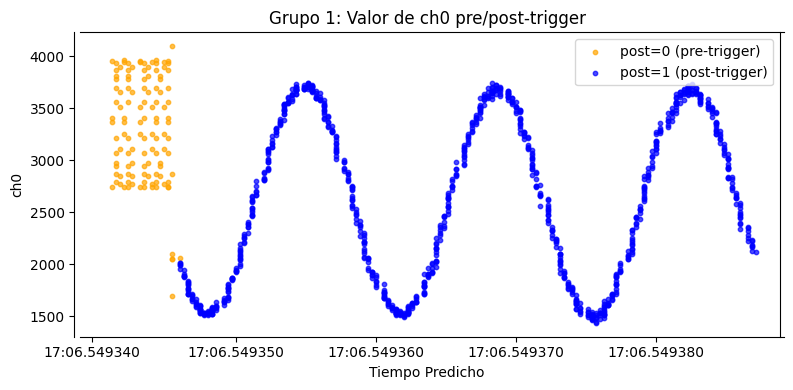

In [4]:
# === Post - Trigger tags ===

# Params
padding = 15


# ---
df['post'] = 0


# 2) Iterar por cada grupo
for group_id, subdf in df.groupby('group'):
    # Máscara de post-trigger dentro del grupo
    mask_trigger = subdf['id'] == '000'
    
    if mask_trigger.any():
        # Índice de la primera fila donde id == '000'
        first_trigger_idx = subdf.index[mask_trigger][0]
        # Índice máximo dentro del grupo
        last_idx = subdf.index[-1]
        
        # 3) Asignar post = 1 desde el trigger hasta el final del grupo
        df.loc[first_trigger_idx + padding :last_idx, 'post'] = 1

# Quitar Nan's
df.dropna()

# 4) Verificar resultados
print(df[['group', 'id', 'post']].query("group == 1").head(10))
print(df[['group', 'id', 'post']].query("group == 1").tail(10))


# ----- Plot ----------


#Sub-DataFrame del grupo
group_id= 1
sub = df[df['group'] == group_id]


mask0 = sub['post'] == 0
mask1 = sub['post'] == 1


if 'predicted_timestamp' in sub.columns:
    x0 = sub.loc[mask0, 'predicted_timestamp']
    x1 = sub.loc[mask1, 'predicted_timestamp']
    xlabel = 'Tiempo Predicho'
else:
    x0 = sub.loc[mask0].index
    x1 = sub.loc[mask1].index
    xlabel = 'Índice'
y0 = sub.loc[mask0, 'ch0']
y1 = sub.loc[mask1, 'ch0']
plt.figure(figsize=(8, 4))
plt.scatter(x0, y0, color='orange', s=10, alpha=0.7, label='post=0 (pre-trigger)')
plt.scatter(x1, y1, color='blue',   s=10, alpha=0.7, label='post=1 (post-trigger)')
plt.xlabel(xlabel)
plt.ylabel('ch0')
plt.title(f'Grupo {group_id}: Valor de ch0 pre/post-trigger')
plt.legend()
plt.tight_layout()
plt.show()


## FFT

In [5]:
## == FFT ==

# Parámetros
signal_col = 'ch0'    # ← Cambia esto por tu columna de interés
dt = 40e-9            # intervalo de muestreo en segundos

# 1) Identificar número de grupos y longitudes post-trigger
grouped = df[df['post']==1].groupby('group')[signal_col]
lengths = grouped.size()
nfft = int(lengths.max())              # FFT de longitud igual al grupo más largo
n_groups = lengths.shape[0]

# 2) Preparar matriz de coeficientes (complex128)
fft_matrix = np.zeros((n_groups, nfft), dtype=np.complex128)

# 3) Calcular FFT para cada grupo
for i, (group_id, series) in enumerate(grouped, start=0):
    signal = series.to_numpy()
    # Padding o truncado a nfft
    if signal.size < nfft:
        signal = np.pad(signal, (0, nfft - signal.size), mode='constant')
    else:
        signal = signal[:nfft]
    # FFT completa
    coeffs = np.fft.fft(signal)
    fft_matrix[i, :] = coeffs

# 4) (Opcional) Eje de frecuencias
freqs = np.fft.fftfreq(nfft, d=dt)

# 5) Resultado: 
#    fft_matrix.shape == (n_groups, nfft)
#    freqs.shape      == (nfft,)
print("Matriz FFT:", fft_matrix.shape)
print("Frecuencias:", freqs.shape)


Matriz FFT: (35, 1020)
Frecuencias: (1020,)


In [6]:
import numpy as np

# 1) Parámetros
signal_col = 'ch0'   # ← tu columna de señal
dt = 40e-9           # intervalo de muestreo en segundos

# 2) Filtrar solo datos post-trigger
post_df = df[df['post'] == 1]

# 3) Agrupar y calcular FFT
fft_dict = {
    group_id: np.fft.fft(series.values)
    for group_id, series in post_df.groupby('group')[signal_col]
}

# 4) (Opcional) Frecuencias para cada grupo
freq_dict = {
    group_id: np.fft.fftfreq(len(series), d=dt)
    for group_id, series in post_df.groupby('group')[signal_col]
}

# 5) Ejemplo de uso: coeficientes del grupo 1
coeffs_g1 = fft_dict[1]
freqs_g1  = freq_dict[1]

print(f"Grupo 1 → {len(coeffs_g1)} bins de FFT")


Grupo 1 → 1020 bins de FFT


In [7]:
df.dropna(inplace=True)

np.sum(df.ch0.isna())

0

In [8]:
import numpy as np

signal_col = 'ch0'   # tu columna de señal

# 0) Si aún no tienes la señal original, reasigna o recarga df[signal_col] aquí:
#    Por ejemplo, si la perdiste, vuelve a leer el CSV o usa un backup que guardaste:
# df = pd.read_csv(...)

# 1) Verifica que sean floats y no hay NaN
print("Tipo:", df[signal_col].dtype)
print("Nulos:", df[signal_col].isna().sum())

# 2) Cálculo directo de la FFT por grupo
fft_dict = {
    gid: np.fft.fft(subdf.loc[subdf['post']==1, signal_col].values)
    for gid, subdf in df.groupby('group')
    if subdf['post'].sum() > 0
}

# 3) Comprobación
print("FFT calculadas en grupos:", sorted(fft_dict.keys()))
print("Bins por grupo ejemplo:", {g: coeffs.size for g, coeffs in fft_dict.items()})


Tipo: float64
Nulos: 0
FFT calculadas en grupos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
Bins por grupo ejemplo: {1: 1019, 2: 1019, 3: 1019, 4: 1019, 5: 1019, 6: 1019, 7: 1019, 8: 1019, 9: 1019, 10: 1019, 11: 1019, 12: 1019, 13: 1019, 14: 1019, 15: 1019, 16: 1019, 17: 1019, 18: 1019, 19: 1019, 20: 1019, 21: 1019, 22: 1019, 23: 1019, 24: 1019, 25: 1019, 26: 1019, 27: 1019, 28: 1019, 29: 1019, 30: 1019, 31: 1019, 32: 1019, 33: 1019, 34: 1019, 35: 1019}


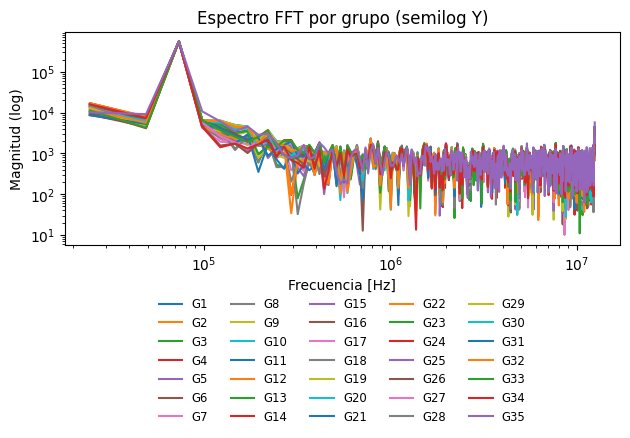

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Puede ser distinto dt
#dt = 40e-9

# --------- FFT logs ----
fig, ax = plt.subplots()

for gid, coeffs in fft_dict.items():
    freqs = np.fft.fftfreq(coeffs.size, d=dt)
    mag = np.abs(coeffs)
    ax.semilogy(freqs[1:coeffs.size//2], mag[1:mag.size//2], label=f"G{gid}")

handles, labels = ax.get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda i: int(labels[i][1:]))
handles = [handles[i] for i in order]
labels  = [labels[i]  for i in order]

ax.legend(handles, labels,
          ncol=5,               # 5 columnas (ajusta según tu gusto)
          fontsize='small',
          loc='upper center',
          bbox_to_anchor=(0.5, -0.2),
          frameon=False)

ax.set_xlabel("Frecuencia [Hz]")
ax.set_ylabel("Magnitud (log)")
ax.set_title("Espectro FFT por grupo (semilog Y)")
ax.set_xscale('log')
plt.tight_layout()
plt.show()




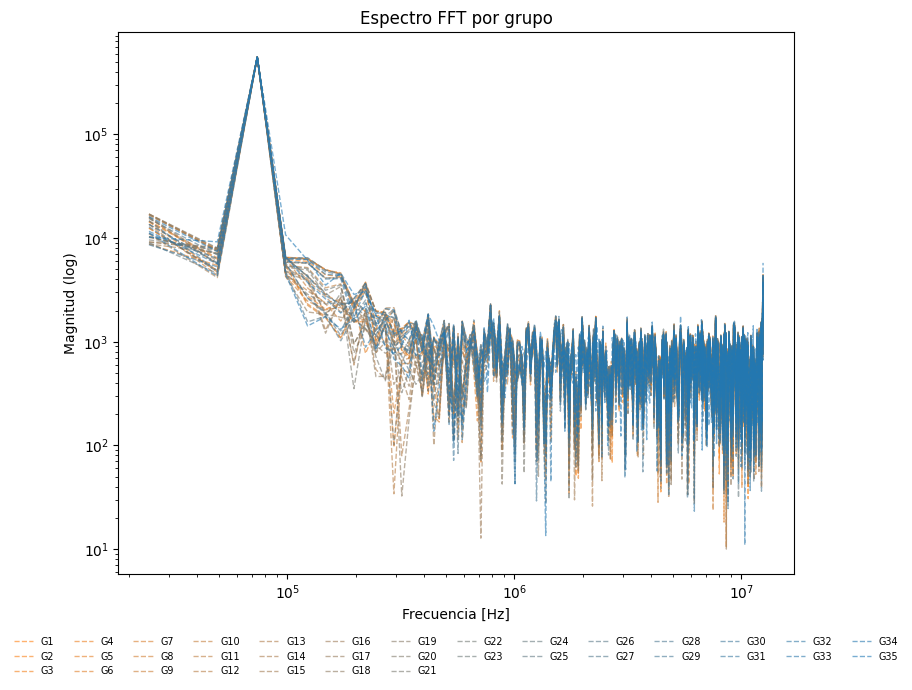

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Parámetros básicos
dt = 40e-9
signal_dict = fft_dict  # {gid: coeffs}
n_groups = len(signal_dict)

# Definir colores de inicio y fin (hex)
start_color = "#FF7F0E"  # naranja
end_color  = "#1F77B4"  # azul


# Crear colormap y extraer n_groups colores
cmap = LinearSegmentedColormap.from_list("gradient", [start_color, end_color])
colors = cmap(np.linspace(0, 1, n_groups))

# Preparar figura
fig, ax = plt.subplots(figsize=(9, 7))

# Trazar cada grupo con su color
for i, gid in enumerate(sorted(signal_dict.keys())):
    coeffs = signal_dict[gid]
    freqs  = np.fft.fftfreq(len(coeffs), d=dt)
    mag    = np.abs(coeffs)
    # Parte positiva (omitimos DC y negativo)
    half = len(coeffs)//2
    ax.semilogy(freqs[1:half], mag[1:half],
                color=colors[i],
                linewidth=1, linestyle='--',
                label=f"G{gid}", alpha=0.6)

ax.legend(ncol=14, fontsize='x-small', frameon=False,
          bbox_to_anchor=(0.5, -0.1), loc='upper center')

ax.set_xscale('log')
ax.set_xlabel("Frecuencia [Hz]")
ax.set_ylabel("Magnitud (log)")
ax.set_title("Espectro FFT por grupo")
plt.tight_layout()
plt.show()


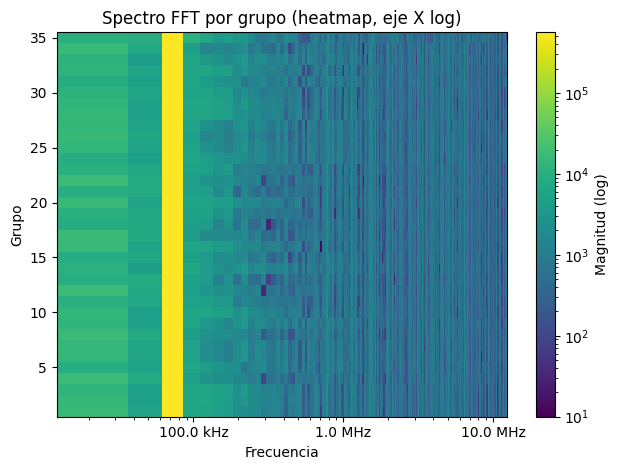

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter

# Parámetros existentes
# freqs_pos: array de frecuencias positivas de longitud M
# mag_matrix: shape (n_groups, M)
# dt: intervalo de muestreo
maxlen =max(c.size for c in fft_dict.values())                # longitud máxima de FFT
mag_matrix = []
for gid in sorted(fft_dict):
    mag = np.abs(fft_dict[gid])
    pad = maxlen - mag.size
    mag = np.pad(mag, (0, pad), mode='constant', constant_values=np.min(mag[mag>0]))
    mag_matrix.append(mag)
mag_matrix = np.vstack(mag_matrix)
# solo hasta el bin 0 de frecuencias
mag_matrix = mag_matrix[:, 1:maxlen//2]

# Parámetros
N =maxlen
n_groups = len(fft_dict)  # número de grupos

# ----

freqs = np.fft.fftfreq(N, d=dt)
freqs_pos = freqs[1:N//2]  # evitamos el bin cero
groups = np.arange(1, mag_matrix.shape[0] + 1)

# Crear malla de coordenadas
X, Y = np.meshgrid(freqs_pos, groups)

fig, ax = plt.subplots()
pcm = ax.pcolormesh(
    X, Y, mag_matrix,
    norm=LogNorm(vmin=mag_matrix[mag_matrix>0].min(),
                 vmax=mag_matrix.max()),
    shading='auto'
)

ax.set_xscale('log')

def hz_fmt(x, pos): # Formatear etiquetas en Hz / kHz / MHz
    if x >= 1e6:
        return f"{x*1e-6:.1f} MHz"
    elif x >= 1e3:
        return f"{x*1e-3:.1f} kHz"
    else:
        return f"{x:.0f} Hz"

ax.xaxis.set_major_formatter(FuncFormatter(hz_fmt))

ax.set_xlabel("Frecuencia") 
ax.set_ylabel("Grupo")
ax.set_title("Spectro FFT por grupo (heatmap, eje X log)")
fig.colorbar(pcm, ax=ax, label="Magnitud (log)")
plt.tight_layout()
plt.show()


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter

def hz_formatter(x, pos):
    """Formatea x en Hz/kHz/MHz para el eje X"""
    if x >= 1e6:
        return f"{x*1e-6:.1f} MHz"
    elif x >= 1e3:
        return f"{x*1e-3:.1f} kHz"
    else:
        return f"{x:.0f} Hz"

def plot_fft_heatmap(
    fft_dict, dt, 
    x_min=None, x_max=None, 
    vmin=None, vmax=None, 
    title="Spectro FFT por grupo (heatmap, eje X log)",
    figsize=(10, 6), show=True,
    vline_freq=None,     # Frecuencia para línea vertical roja (Hz)
    vline_kwargs=None    # Diccionario de kwargs para personalizar la línea
):
    """
    Grafica un heatmap logarítmico de los espectros FFT por grupo.

    Parámetros
    ----------
    fft_dict : dict
        Diccionario {group_id: coeficientes FFT (array complejo)}.
    dt : float
        Intervalo de muestreo en segundos.
    x_min, x_max : float, opcional
        Límites de frecuencia en Hz para recortar el eje X.
    vmin, vmax : float, opcional
        Límites mínimo y máximo de la escala de color (magnitud).
    title : str
        Título de la figura.
    figsize : tuple, opcional
        Tamaño de la figura (ancho, alto).
    show : bool, opcional
        Si True, llama a plt.show().
    vline_freq : float, opcional
        Frecuencia en Hz donde trazar una línea vertical roja.
    vline_kwargs : dict, opcional
        Parámetros adicionales para ax.axvline (color, linestyle, alpha, etc.).

    Retorna
    -------
    fig, ax : matplotlib.figure.Figure, matplotlib.axes.Axes
        Objeto figura y ejes del plot.
    """
    # 1) Determinar N y frecuencias
    N = max(len(coeffs) for coeffs in fft_dict.values())
    freqs = np.fft.fftfreq(N, d=dt)
    freqs_pos = freqs[1:N//2]  # descartamos DC y parte negativa

    # 2) Máscara de recorte de eje X
    mask = np.ones_like(freqs_pos, dtype=bool)
    if x_min is not None:
        mask &= freqs_pos >= x_min
    if x_max is not None:
        mask &= freqs_pos <= x_max
    freqs_plot = freqs_pos[mask]

    # 3) Construir la matriz de magnitudes
    mag_list = []
    group_ids = sorted(fft_dict.keys())
    for gid in group_ids:
        mag = np.abs(fft_dict[gid])[1:N//2]
        if mag.size < freqs_pos.size:
            pad = freqs_pos.size - mag.size
            fill_val = np.min(mag[mag>0]) if np.any(mag>0) else 0
            mag = np.pad(mag, (0, pad), mode='constant', constant_values=fill_val)
        mag_list.append(mag[mask])
    mag_matrix = np.vstack(mag_list)
    groups = np.arange(1, len(group_ids) + 1)

    # 4) Plot
    fig, ax = plt.subplots(figsize=figsize)
    if vmin is None:
        vmin = mag_matrix[mag_matrix>0].min()
    if vmax is None:
        vmax = mag_matrix.max()

    X, Y = np.meshgrid(freqs_plot, groups)
    pcm = ax.pcolormesh(
        X, Y, mag_matrix,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        shading='auto'
    )
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(hz_formatter))
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Group Index")
    ax.set_title(title)

    # 5) Línea vertical opcional
    if vline_freq is not None and (mask & (freqs_pos == freqs_pos)).any():
        if x_min is not None and vline_freq < x_min:
            pass
        elif x_max is not None and vline_freq > x_max:
            pass
        else:
            # Personalizar kwargs
            lw = {'color': 'red', 'linestyle': '--', 'linewidth': 1.5, 'alpha': 0.8, 'zorder': 10}
            if vline_kwargs:
                lw.update(vline_kwargs)
            ax.axvline(vline_freq, **lw)

    fig.colorbar(pcm, ax=ax, label="Mag (log)")

    plt.tight_layout()
    if show:
        plt.show()

    return fig, ax


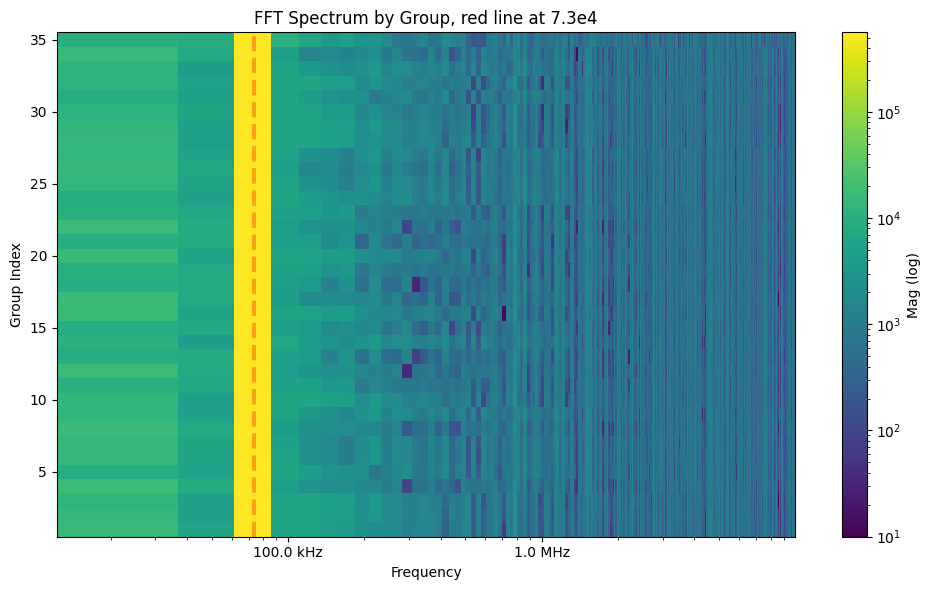

(<Figure size 1000x600 with 2 Axes>,
 <Axes: title={'center': 'FFT Spectrum by Group, red line at 7.3e4'}, xlabel='Frequency', ylabel='Group Index'>)

In [36]:
plot_fft_heatmap(fft_dict, dt, x_min=1e4, x_max=1e7, title=f"FFT Spectrum by Group, red line at 7.3e4",
                 vline_freq=73601, vline_kwargs={'linewidth':3, 'alpha':0.3})


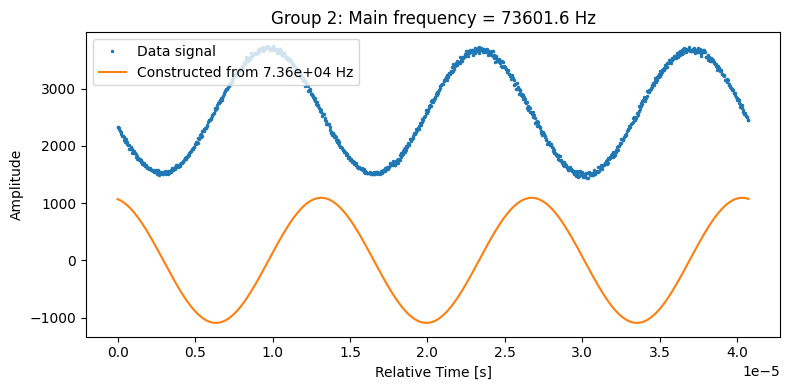

73601.57016683022


In [74]:
# === construccion de ondas para comprar ====

# Parámetros
group_id   = 2            # ← el grupo que quieras analizar
signal_col = 'ch0'         # ← tu columna de señal


# 1) Señal y tiempo del grupo (solo post-trigger)
sub = df[df['group'] == group_id]
mask = sub['post'] == 1
# Tiempo relativo en segundos
t0 = sub.loc[mask, 'predicted_timestamp'].iloc[0]
t  = (sub.loc[mask, 'predicted_timestamp'] - t0).dt.total_seconds().values
x  = sub.loc[mask, signal_col].values

# 2) FFT y detección de pico
coeffs   = fft_dict[group_id]
freqs    = np.fft.fftfreq(coeffs.size, d=dt)
mag      = np.abs(coeffs)
half     = coeffs.size // 2
idx_peak = np.argmax(mag[1:half]) + 1

# 3) Parámetros de la sinusoide
f0    = freqs[idx_peak]
amp   = 2 * mag[idx_peak] / coeffs.size      # factor 2/N para amplitud real
phase = np.angle(coeffs[idx_peak])

# 4) Generar sinusoide
sine = amp * np.sin(2 * np.pi * f0 * t + phase)

# 5) Graficar comparación
plt.figure(figsize=(8, 4))
plt.plot(t, x,   '.', markersize=3, label='Data signal')
plt.plot(t, sine, '-', linewidth=1.5, label=f'Constructed from {f0:.2e} Hz')
plt.xlabel('Relative Time [s]')
plt.ylabel('Amplitude')
plt.title(f'Group {group_id}: Main frequency = {f0:.1f} Hz')
plt.legend()
plt.tight_layout()
plt.show()


# ---
f0 # frecuencia principal
##---
print(f0)


## La dispersión en la diferencia
Muchas frecuencias poseen coeficientes similares, pero otras poseen diferencias visibles entre grupos

Top 5 frecuencias con mayor variación:
  24.53 kHz  →  σ = 2833.2
  73.60 kHz  →  σ = 2511.2
  122.67 kHz  →  σ = 1552.7
  49.07 kHz  →  σ = 1343.9
  171.74 kHz  →  σ = 1214.6


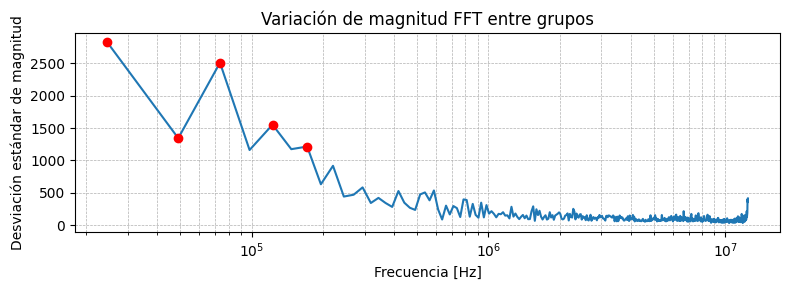

In [ ]:
# std para cada bin de freq
stds = np.std(mag_matrix, axis=0)  # shape: (n_bins,)

# Obtener índices de mayor variación (por ejemplo top 5)
n_top = 5
top_idx = np.argsort(stds)[-n_top:][::-1]  # índices de los n_top bins más variables
top_freqs = freqs_pos[top_idx]             # frecuencias correspondientes
top_stds  = stds[top_idx]                  # sus desviaciones

# Mostrar resultados
print(f"Top {n_top} frecuencias con mayor variación:")
for f, s in zip(top_freqs, top_stds):
    unit = "Hz" if f<1e3 else ("kHz" if f<1e6 else "MHz")
    val = f if f<1e3 else (f/1e3 if f<1e6 else f/1e6)
    print(f"  {val:.2f} {unit}  →  σ = {s:.1f}")

# Graficar σ vs frecuencia
plt.figure(figsize=(8,3))
plt.semilogx(freqs_pos, stds, '-')
plt.scatter(top_freqs, top_stds, color='red', zorder=5)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Desviación estándar de magnitud")
plt.title("Variación de magnitud FFT entre grupos")
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

# un problema son las distintas unidades
# no se encuentran normalizados
# frecuencias bajas con mayor magnitud de coeficiente producirian un sesgo


Top 5 frecuencias por Coef. de Variación:
  8.59 MHz → CV = 1.053
  1.74 MHz → CV = 0.878
  1.37 MHz → CV = 0.829
  7.51 MHz → CV = 0.712
  2.43 MHz → CV = 0.710


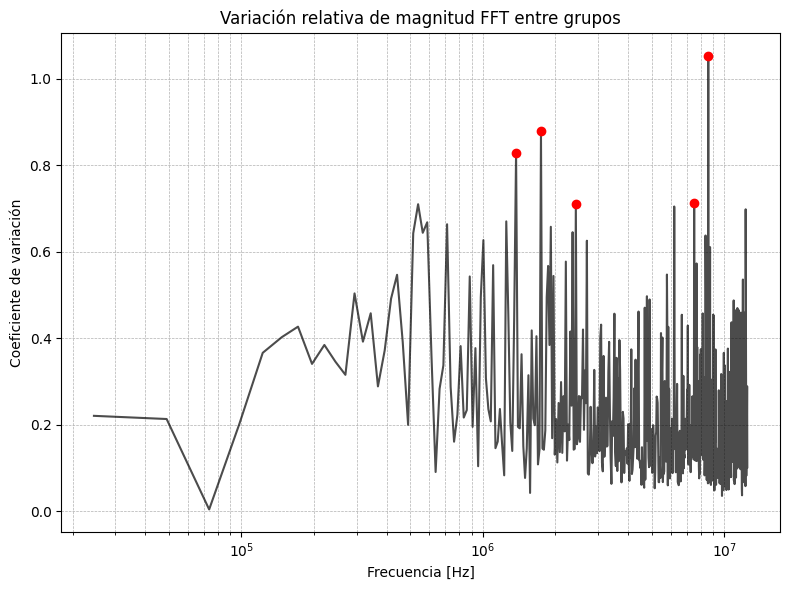

In [58]:
# === Coeficiente de Variación por bin de frecuencia ===


# mag_matrix: array shape (n_groups, n_bins)
# freqs_pos: array shape (n_bins,)

# Calcular media y desviación estándar por bin
means = mag_matrix.mean(axis=0)
stds  = mag_matrix.std(axis=0)

# Coeficiente de variación (CV = σ / μ)
cvs = stds / means

# Top 5 bins con mayor CV
n_top = 5
top_idx   = np.argsort(cvs)[-n_top:][::-1]
top_freqs = freqs_pos[top_idx]
top_cvs   = cvs[top_idx]

print(f"Top {n_top} frecuencias por Coef. de Variación:")
for f, cv in zip(top_freqs, top_cvs):
    unit = "Hz" if f<1e3 else ("kHz" if f<1e6 else "MHz")
    val  = f if f<1e3 else (f/1e3 if f<1e6 else f/1e6)
    print(f"  {val:.2f} {unit} → CV = {cv:.3f}")

# Graficar CV vs frecuencia
plt.figure(figsize=(8, 6))
plt.semilogx(freqs_pos, cvs, '-k', alpha=0.7)
plt.scatter(top_freqs, top_cvs, color='red', zorder=5)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Coeficiente de variación")
plt.title("Variación relativa de magnitud FFT entre grupos")
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()


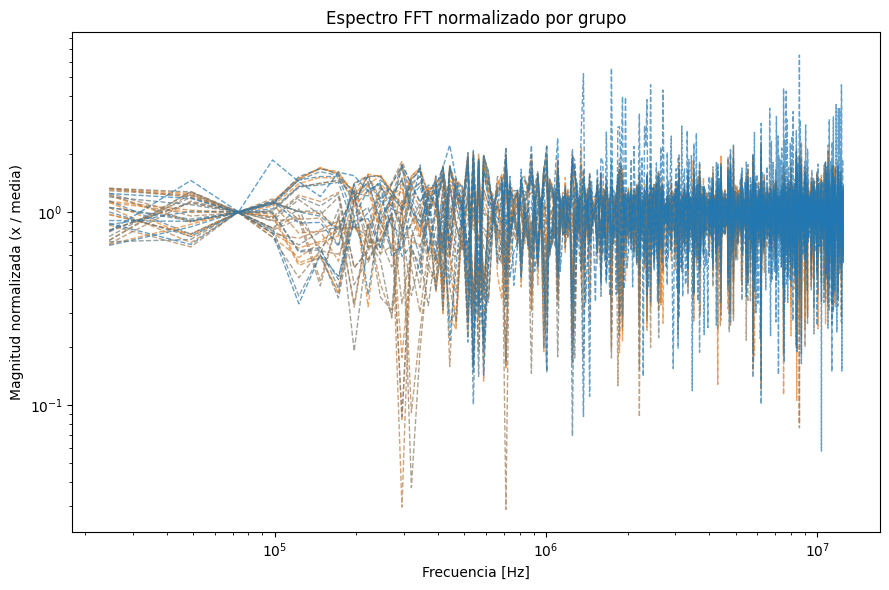

In [57]:
from matplotlib.colors import LinearSegmentedColormap

# Parámetros básicos
dt = 40e-9
signal_dict = fft_dict  # {gid: coeffs}
n_groups = len(signal_dict)

# Crear gradiente de colores
start_color = "#FF7F0E"  # naranja
end_color   = "#1F77B4"  # azul
cmap = LinearSegmentedColormap.from_list("gradient", [start_color, end_color])
colors = cmap(np.linspace(0, 1, n_groups))

# 1) Preparar matriz de magnitudes uniforme
coeffs_list = [signal_dict[gid] for gid in sorted(signal_dict)]
N = max(len(c) for c in coeffs_list)
half = N // 2

mag_list = []
for coeffs in coeffs_list:
    magfull = np.abs(coeffs)
    # Paddear al tamaño máximo N
    if len(magfull) < N:
        pad = N - len(magfull)
        fill_val = np.min(magfull[magfull>0]) if np.any(magfull>0) else 0
        magfull = np.pad(magfull, (0, pad), mode='constant', constant_values=fill_val)
    mag_list.append(magfull[1:half])  # descartamos DC

mag_matrix = np.vstack(mag_list)  # shape: (n_groups, half-1)
freqs = np.fft.fftfreq(N, d=dt)[1:half]  # frecuencias positivas

# 2) Calcular media por bin y normalizar
mean_mag = mag_matrix.mean(axis=0)
mag_norm = mag_matrix / mean_mag  # ratio respecto a la media

# 3) Graficar
fig, ax = plt.subplots(figsize=(9, 6))
for i, (gid, mag_row) in enumerate(zip(sorted(signal_dict), mag_norm)):
    ax.semilogy(freqs, mag_row, color=colors[i], linewidth=1, linestyle='--', alpha=0.7)

ax.set_xscale('log')
ax.set_xlabel("Frecuencia [Hz]")
ax.set_ylabel("Magnitud normalizada (x / media)")
ax.set_title("Espectro FFT normalizado por grupo")
plt.tight_layout()
plt.show()


## Evolución

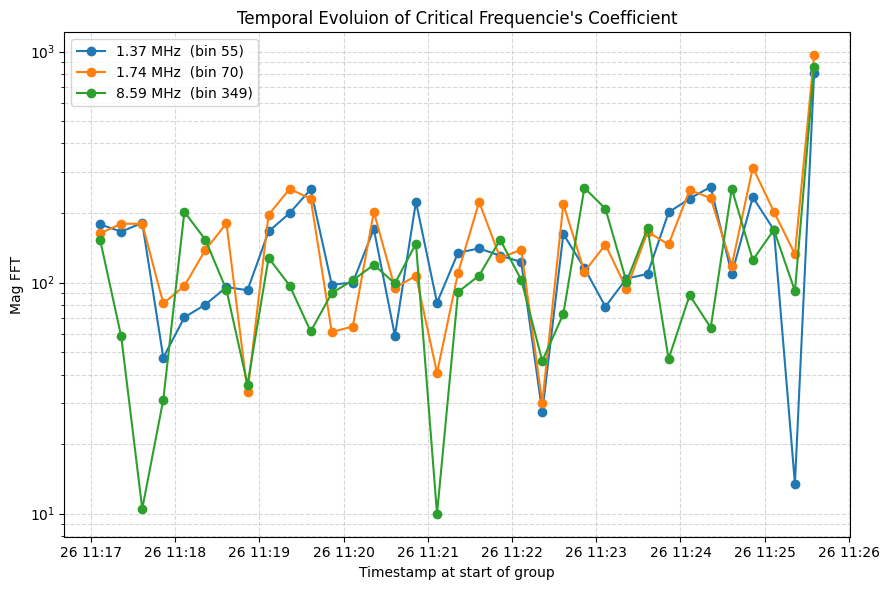

In [136]:

# --- Datos ya preparados ---
# mag_matrix: array (n_groups, n_bins) de magnitudes FFT
# freqs_pos: array (n_bins,) de frecuencias positivas
group_starts = indices
f0 # frecuencia principal en Hz

# 1) Timestamp de inicio de cada grupo
group_ts = [df.loc[idx, 't'] for idx in group_starts]

# 2) Frecuencias de interés y sus bins
targets = [1.37e6, 1.74e6, 8.59e6]  # en Hz
idxs    = [np.argmin(np.abs(freqs_pos - f)) for f in targets]

# 3) Extraer series de magnitud para cada frecuencia
data = {}
for f, idx in zip(targets, idxs):
    data[f] = mag_matrix[:, idx]

# 4) Graficar evolución temporal
plt.figure(figsize=(9,6))
for f, idx in zip(targets, idxs):
    y = data[f]
    plt.plot(group_ts, y, marker='o', linestyle='-',
             label=f"{f/1e6:.2f} MHz  (bin {idx})")
    
plt.xlabel("Timestamp at start of group")
plt.ylabel("Mag FFT")
plt.title("Temporal Evoluion of Critical Frequencie's Coefficient")
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


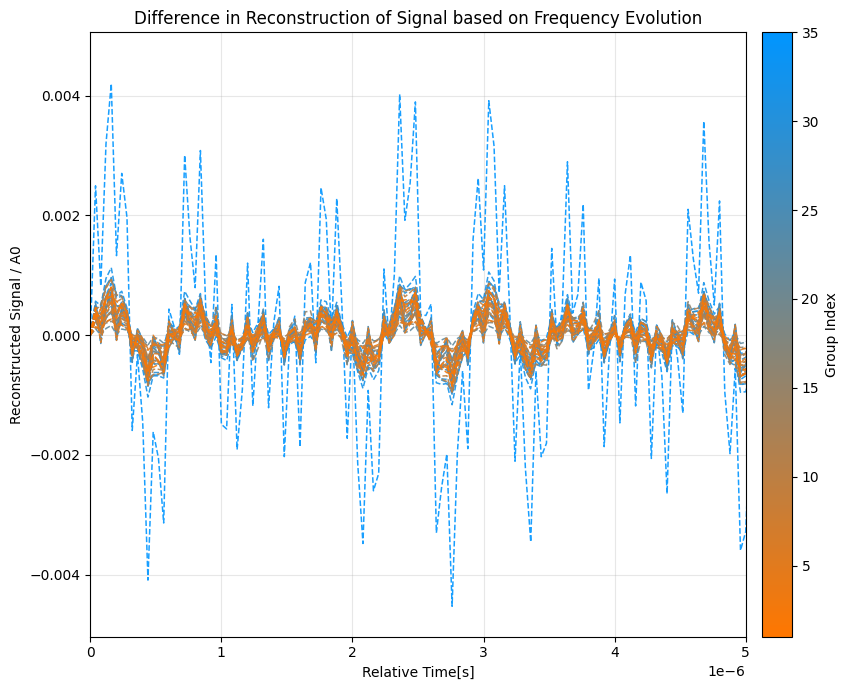

(<Figure size 900x700 with 2 Axes>,
 <Axes: title={'center': 'Difference in Reconstruction of Signal based on Frequency Evolution'}, xlabel='Relative Time[s]', ylabel='Reconstructed Signal / A0'>)

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.cm as cm

def plot_reconstruction_gradient(
    df, fft_dict, dt, f0, corrections,
    start_color="#FF7F0E", end_color="#1F77B4",
    normalize_base=True, invert_colors=True,
    figsize=(8, 5), xupper = 5e-6
):
    """
    Grafica reconstrucciones sinusoidales para cada grupo en un solo eje,
    con un gradiente de color que indica el índice de grupo.
    
    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame con columnas 'group', 'post', 'predicted_timestamp' y la señal 'ch0'.
    fft_dict : dict
        Diccionario {group_id: array de coeficientes FFT (complejos)}.
    dt : float
        Intervalo de muestreo en segundos.
    f0 : float
        Frecuencia base en Hz.
    corrections : list of float
        Lista de frecuencias de corrección en Hz.
    start_color, end_color : str
        Colores extremos del gradiente (hex o nombre).
    normalize_base : bool
        Si True normaliza la señal reconstruida por la amplitud A0.
    invert_colors : bool
        Si True invierte el orden del gradiente de color.
    figsize : tuple
        Tamaño de la figura (ancho, alto).
    
    Retorna
    -------
    fig, ax : matplotlib.figure.Figure, matplotlib.axes.Axes
    """
    group_ids = sorted(fft_dict.keys())
    n_groups = len(group_ids)
    
    # Construir colormap
    cmap = LinearSegmentedColormap.from_list("grad", [start_color, end_color])
    linspace = np.linspace(1, 0, n_groups) if invert_colors else np.linspace(0, 1, n_groups)
    colors = cmap(linspace)
    
    norm = Normalize(vmin=1, vmax=n_groups)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for i, gid in enumerate(group_ids[::-1]):
        # Señal y tiempo relativo
        sub = df[df['group'] == gid]
        mask = sub['post'] == 1
        t0 = sub.loc[mask, 'predicted_timestamp'].iloc[0]
        t = (sub.loc[mask, 'predicted_timestamp'] - t0).dt.total_seconds().values
        
        # FFT del grupo
        coeffs = fft_dict[gid]
        N = len(coeffs)
        freqs = np.fft.fftfreq(N, d=dt)
        
        # Parámetros de sinusoidal base
        idx0 = np.argmin(np.abs(freqs - f0))
        A0 = 2 * np.abs(coeffs[idx0]) / N
        
        # Reconstruir señal
        s = np.zeros_like(t)
        for f_j in ( corrections):
            idxj = np.argmin(np.abs(freqs - f_j))
            Aj = 2 * np.abs(coeffs[idxj]) / N
            phi_j = np.angle(coeffs[idxj])
            s += Aj * np.sin(2 * np.pi * f_j * t)
        
        # Normalizar si corresponde
        if normalize_base and A0 != 0:
            s = s / A0
        
        ax.plot(
            t, s,
            color=colors[i],
            linewidth=1.1, alpha=0.9, linestyle='--'
        )
    
    ax.set_xlabel("Relative Time[s]")
    ax.set_ylabel("Reconstructed Signal" + (" / A0" if normalize_base else ""))
    ax.set_title("Difference in Reconstruction of Signal based on Frequency Evolution")
    ax.grid(True, alpha=0.3)

    ax.set_xlim(0, xupper)
    
    # Colorbar indica grupo
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("Group Index")
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax


# ---
plot_reconstruction_gradient(
    df, fft_dict, dt, f0, corrections,
    start_color="#FF7700", end_color="#0095FF",
    normalize_base=True, invert_colors=True,
    figsize=(9, 7)
)

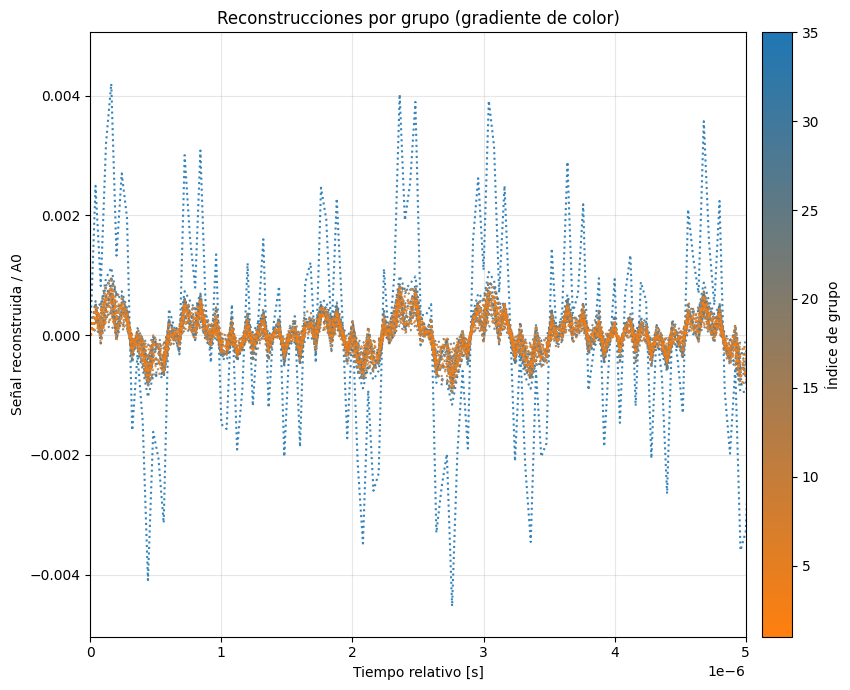

(<Figure size 900x700 with 2 Axes>,
 <Axes: title={'center': 'Reconstrucciones por grupo (gradiente de color)'}, xlabel='Tiempo relativo [s]', ylabel='Señal reconstruida / A0'>)